In [159]:
!pip install tensorflow_text

In [160]:
import os
import shutil
import re
import json
import gc

import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import matplotlib.pyplot as plt
plt.style.use('ggplot')

tf.get_logger().setLevel('ERROR')

In [161]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Preprocessing

In [162]:
data_file_name_dict = {
    '2014':'bostonglobe2014.csv',
    '2015':'bostonglobe2016.csv',
    '2016':'bostonglobe2015.csv',
    '2017':'bostonglobe2017.csv',
    '2018':'bostonglobe2018.csv',
}

In [188]:
def tokenize(text, split_tokens=False):
    tokens = []
    for token in nltk.word_tokenize(text):
      if (token.isalnum() or (token.find('-') > 0)):
        tokens.append(token)
    if split_tokens:
      return tokens
    else:
      return " ".join(tokens)

In [166]:
def clean_text(text):
    # text = re.sub(r"[\[\]]", "", text)
    text = re.sub(r"['\['\]]", "", text)
    text = re.sub(r"\n", "", text.lower())
    # text = tokenize(text)
    return text

In [167]:
def extract_sentences(text):
    """
        extract sentences from text file
    """
    # tokenized_words = tokenize(text)
    sentences = nltk.sent_tokenize(text)
    sentences = [tokenize(sentence) for sentence in sentences]
    return  sentences

In [168]:
def process_files(file_names):
  data_frames = {}
  for key, val in file_names.items():
    df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/data/boston-globe/{val}')
    df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    df['text'] = df['text'].apply(clean_text)
    # df['sentences'] = df['text'].apply(extract_sentences)
    data_frames[f"{key}"] = df
  return data_frames

In [190]:
processed_dfs = process_files(data_file_name_dict)

In [170]:
model_fname = 'IMDB_BERT_CLASSIFIER_5'
my_wd = '/content/drive/MyDrive/Colab Notebooks/Models/'
saved_model_path = os.path.join(my_wd, model_fname)

#### load saved model

In [171]:
model = tf.saved_model.load(saved_model_path)

In [172]:
def process_articles(articles, anchor_token, next_token, span):
  span = 4 if span > 3 else span+1
  selected_articles = []
  for article in articles:
    tokens = tokenize(article, split_tokens=True)
    token_length = len(tokens)
    for i in range(token_length):
      min_start_index = max(i-span, 0)
      min_end_index = min(i+span, token_length)
      if (tokens[i] == anchor_token and (next_token in tokens[i: min_end_index] or next_token in tokens[min_start_index: i])):
        selected_articles.append(article)
     
  print(selected_articles[0])
  print(f"selected {len(selected_articles)} of {len(articles)} articles")
  return selected_articles

In [174]:
def write_to_file(document, file):
    document = json.dumps(document)
    with open(file, 'w') as f:
        f.write(document)
    print("file write to disk complete")

In [175]:
def get_word_sentiment(data_frames, anchor_token, next_token, span=2, write_to_disk=False):
  total_sentiment_frequency = {}

  for key, df in data_frames.items():
    pred_sentences = process_articles(df['text'], anchor_token, next_token, span)
    
    parsed_results = tf.sigmoid(model(tf.constant(pred_sentences))).numpy()
    sentiment_frequency = { 
      "Negative": 0,
      "Positive": 0,
    }
    for i in parsed_results:
      if (i[0] > 0.5):
        sentiment_frequency['Positive'] += 1
      else:
        sentiment_frequency['Negative'] += 1
    total_sentiment_frequency[key] = sentiment_frequency
    if (write_to_disk):
      file = f'/content/drive/MyDrive/Colab Notebooks/results/total_sentiment_frequency'
      write_to_file(total_sentiment_frequency, file)
  return total_sentiment_frequency

In [191]:
sentiment_frequency = get_word_sentiment(processed_dfs, "african-american", "woman", 3)

\ntook on the tough job of running massachusetts’ public transit system, beverly a. scott said she was prepared to “crack a few eggs to make an omelet.”consider those eggs cracked with scott’s shocking recommendation that the mbta should drop its longtime, politically wired commuter rail operator — the massachusetts bay commuter railroad — in favor of a french firm, keolis commuter services.  the massachusetts department of transportation’s board of directors backed her up, awarding a nearly $3 billion contract to an outsider challenging a hometown favorite. that happens rarely in massachusetts, and it’s probably no coincidence that it happened under the leadership of another outsider like scott. she’s the first african-american woman to head the t and a newcomer to the bay state political stage.conventional wisdom suggested that massachusetts bay commuter railroad had everything teed up for another lucrative t contract. jim o’leary, a former mbta general manager, founded massachusetts

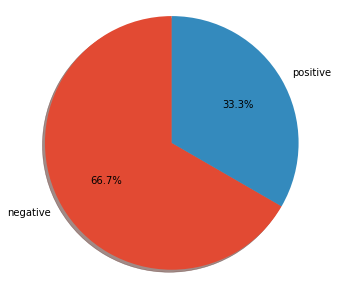

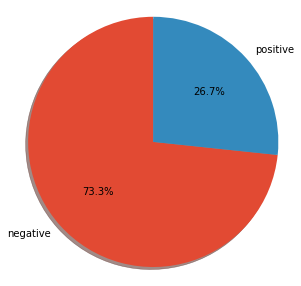

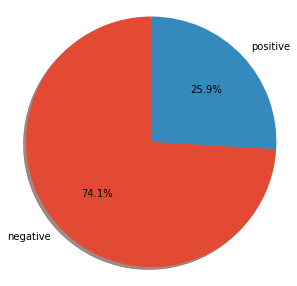

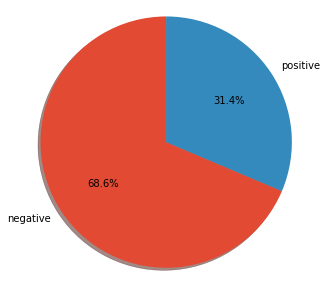

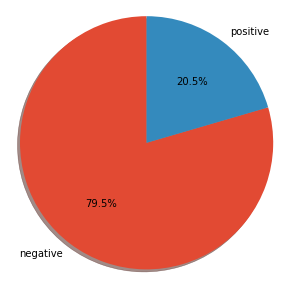

In [192]:
for key, val in sentiment_frequency.items():
  fig = plt.figure(figsize=(5, 5))

  labels = 'Positives', 'Negative'

  plt.pie([val['Negative'], val['Positive']], labels=['negative', 'positive'], autopct='%1.1f%%', shadow=True, startangle=90)
  plt.axis('equal')  
  plt.show()

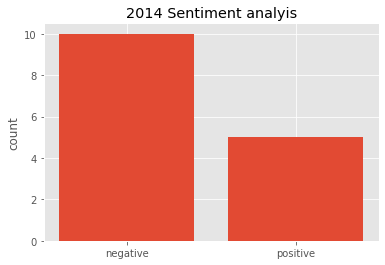

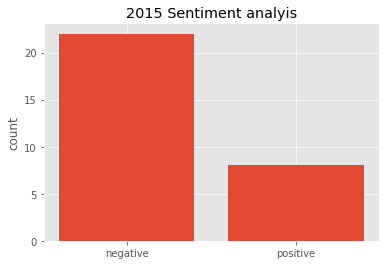

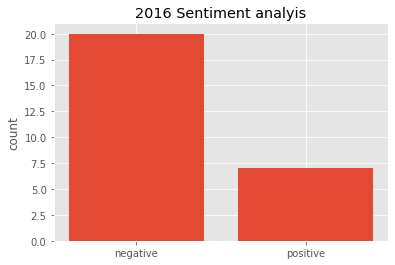

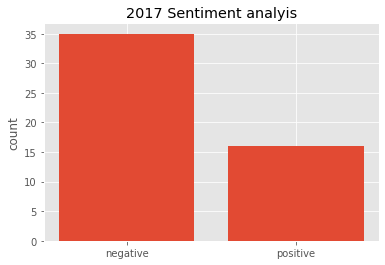

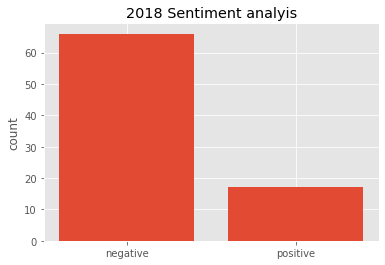

In [193]:
for key, val in sentiment_frequency.items():
  plt.title(f'{key} Sentiment analyis')
  plt.bar(['negative', 'positive'], [val['Negative'], val['Positive']])
  plt.ylabel('count')
  plt.show()
  